In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.utils import check_array
from keras.models import load_model
from keras.layers import Bidirectional
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from numpy import array
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
from scipy import stats
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.layers import Dense,LSTM,Dropout,Activation
import os
from pandas import DataFrame
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
df=pd.read_csv('alpha_death.csv')
df.head()

death
0     93
1    201
2    287
3    373
4    451

In [3]:
train_df,test_df =df[1:int(0.75 * len(df))],df[int(0.75 * len(df)):] 

In [4]:
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_1264/3151536076.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_1264/3151536076.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i]=s_s


In [5]:
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
    # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [14]:
n_past = 5
n_future =7
n_features = 1

In [15]:
X_train, y_train = split_series(train.values,n_past, n_future)

In [16]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [84]:
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 5, 1)]       0           []                               
                                                                                                  
 lstm_28 (LSTM)                 [(None, 5, 100),     40800       ['input_8[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_29 (LSTM)                 [(None, 100),        80400       ['lstm_28[0][0]']                
                                 (None, 100),                                               

In [85]:

model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history=model.fit(X_train,y_train,epochs=100,validation_split = 0.2,batch_size=16,verbose=0)

In [34]:
model=load_model("LSTM_3days.h5")
#model=model.save("LSTM_3days.h5")

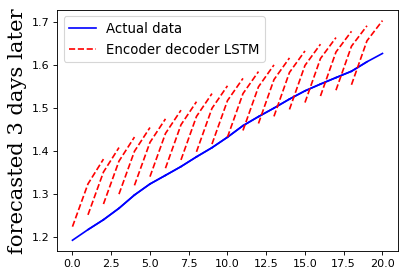

In [35]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)

pred3LSTM=model.predict(X_test)
font1 = {'family':'Serif','color':'black','size':19}


for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred3LSTM[i],"red",linestyle='dashed')
    #plt.title("Encoder decoder LSTM", fontdict = font1)
    #plt.xlabel("days")   
    plt.ylabel("forecasted 3 days later", fontdict = font1)
    plt.legend(['Actual data','Encoder decoder LSTM'],fontsize=12)
    


In [36]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))    

death
Day  1 :
MAE-E2D2 :  0.021709412410858192
Day  2 :
MAE-E2D2 :  0.08135450817487772
Day  3 :
MAE-E2D2 :  0.11178500674519153


mean 0.07161630911030914


In [37]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))    

death
Day  1 :
MAE-E2D2 :  1.5745273017635268
Day  2 :
MAE-E2D2 :  5.864903540246252
Day  3 :
MAE-E2D2 :  7.889306673027593


mean 5.1095791716791235


In [38]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))   



death
Day  1 :
MAE-E2D2 :  0.023802704193683813
Day  2 :
MAE-E2D2 :  0.08376180532417363
Day  3 :
MAE-E2D2 :  0.11360572838625485


mean 0.0737234126347041


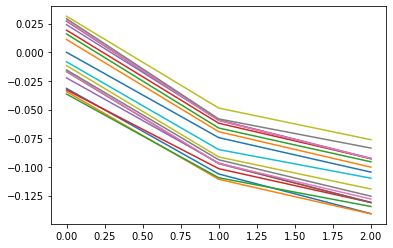

In [39]:
#residual plot

residuals = y_test-pred3LSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)
    


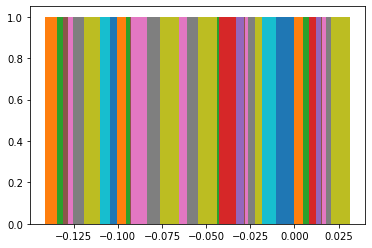

In [40]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

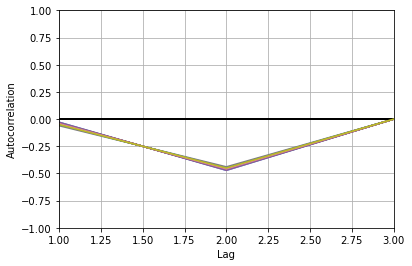

In [41]:
from pandas.plotting import autocorrelation_plot
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)

In [9]:
model=load_model("LSTM_5days.h5")
#model=model.save("LSTM_5days.h5")

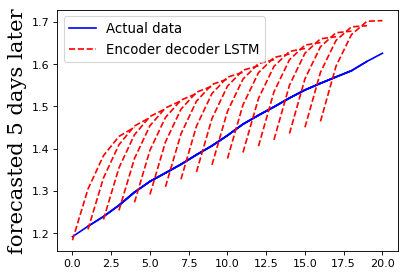

In [10]:
pred5LSTM=model.predict(X_test)
font1 = {'family':'Serif','color':'black','size':19}
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)

for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred5LSTM[i],"red",linestyle='dashed')
    plt.ylabel("forecasted 5 days later", fontdict = font1)
    #plt.xlabel("days")   
    plt.legend(['Actual data','Encoder decoder LSTM'],fontsize=12)
#plt.legend()

In [11]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))   


death
Day  1 :
MAE-E2D2 :  0.0540447514633967
Day  2 :
MAE-E2D2 :  0.062376091447003595
Day  3 :
MAE-E2D2 :  0.11504133802857794
Day  4 :
MAE-E2D2 :  0.13134470086023237
Day  5 :
MAE-E2D2 :  0.12178809583860127


mean 0.09691899552756238


In [63]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))    

death
Day  1 :
MAE-E2D2 :  3.1614076568781324
Day  2 :
MAE-E2D2 :  4.276102119945277
Day  3 :
MAE-E2D2 :  8.080591227135988
Day  4 :
MAE-E2D2 :  9.092447327494117
Day  5 :
MAE-E2D2 :  8.261240826546612


mean 6.574357831600025


In [64]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))    

death
Day  1 :
MAE-E2D2 :  0.045760752936566895
Day  2 :
MAE-E2D2 :  0.05793405838720737
Day  3 :
MAE-E2D2 :  0.1130947243597611
Day  4 :
MAE-E2D2 :  0.12945217429608696
Day  5 :
MAE-E2D2 :  0.11910566139741734


mean 0.09306947427540793


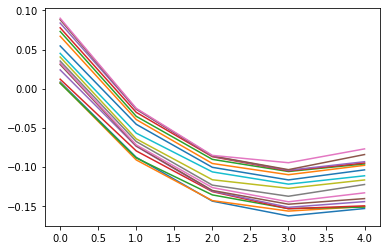

In [12]:
#residual plot

residuals = y_test-pred5LSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)
    

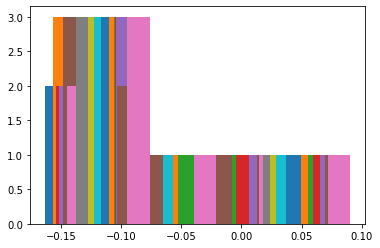

In [66]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

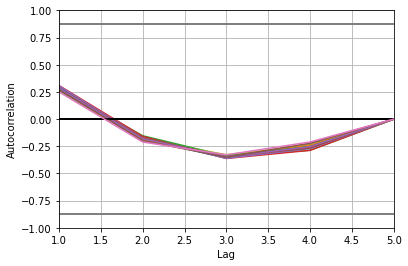

In [67]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)

F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel

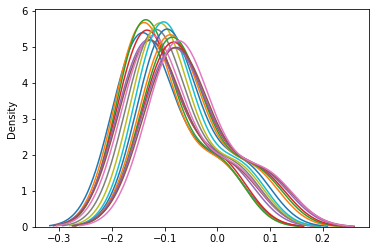

In [13]:
import seaborn as sns
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    sns.distplot(residual, hist=False)

In [17]:
model=load_model("LSTM_7days.h5")
#model=model.save("LSTM_7days.h5")

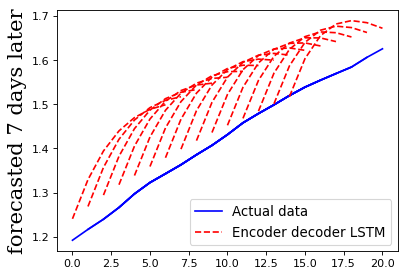

In [18]:
pred7LSTM=model.predict(X_test)
font1 = {'family':'Serif','color':'black','size':19}
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)

for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred7LSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    plt.ylabel("forecasted 7 days later", fontdict = font1)
    plt.legend(['Actual data','Encoder decoder LSTM'],fontsize=12)


In [19]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))   

death
Day  1 :
MAE-E2D2 :  0.03057177830430957
Day  2 :
MAE-E2D2 :  0.09417265738990264
Day  3 :
MAE-E2D2 :  0.1297666771318595
Day  4 :
MAE-E2D2 :  0.14300764064536894
Day  5 :
MAE-E2D2 :  0.14000397360503847
Day  6 :
MAE-E2D2 :  0.12555381329283183
Day  7 :
MAE-E2D2 :  0.10345497171641561


mean 0.10950450172653235


In [91]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))   

death
Day  1 :
MAE-E2D2 :  2.3523954149329667
Day  2 :
MAE-E2D2 :  6.924904683503534
Day  3 :
MAE-E2D2 :  9.357689116267892
Day  4 :
MAE-E2D2 :  10.148956417728577
Day  5 :
MAE-E2D2 :  9.799395322291176
Day  6 :
MAE-E2D2 :  8.691012901612654
Day  7 :
MAE-E2D2 :  7.102211802417916


mean 7.76808080839353


In [92]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))   


death
Day  1 :
MAE-E2D2 :  0.03538399072533073
Day  2 :
MAE-E2D2 :  0.0957590144002073
Day  3 :
MAE-E2D2 :  0.1311070959001645
Day  4 :
MAE-E2D2 :  0.1445961841003391
Day  5 :
MAE-E2D2 :  0.14219856855076982
Day  6 :
MAE-E2D2 :  0.1290548329087043
Day  7 :
MAE-E2D2 :  0.10926077771256394


mean 0.1124800663282971


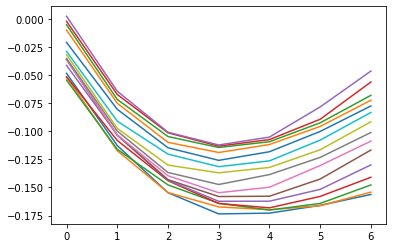

In [20]:
#residual plot

residuals = y_test-pred7LSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)
    

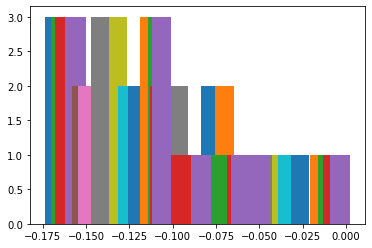

In [94]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

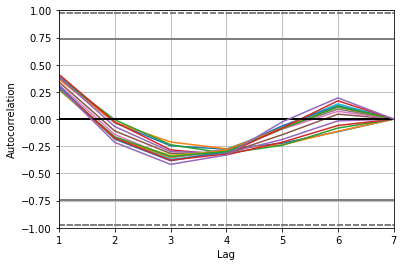

In [95]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)

F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel

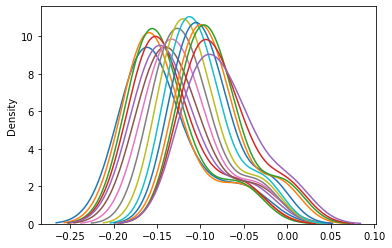

In [21]:
import seaborn as sns
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    sns.distplot(residual, hist=False)

In [ ]:
#BiLSTM

In [96]:
train_df,test_df =df[1:int(0.75 * len(df))],df[int(0.75 * len(df)):] 
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_2796/3905142482.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_2796/3905142482.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i]=s_s


In [97]:
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
    # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [119]:
n_past = 5
n_future =7
n_features = 1
X_train, y_train = split_series(train.values,n_past, n_future)

In [120]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [188]:
#define model
model = Sequential()
model.add(Bidirectional(LSTM(150, return_sequences=True), input_shape=(n_past, n_features)))
model.add(Bidirectional(LSTM(128,activation='relu')))
model.add(Dense(128))
model.add(Dense(n_future))
model.compile(loss='mean_squared_error', optimizer='Adam')

In [189]:
history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2, batch_size = 8)

Epoch 1/100
7/7 [==============================] - 10s 320ms/step - loss: 0.2317 - val_loss: 0.5116
Epoch 2/100
7/7 [==============================] - 0s 63ms/step - loss: 0.0587 - val_loss: 0.5118
Epoch 3/100
7/7 [==============================] - 0s 58ms/step - loss: 0.0568 - val_loss: 0.4853
Epoch 4/100
7/7 [==============================] - 1s 80ms/step - loss: 0.0315 - val_loss: 0.4413
Epoch 5/100
7/7 [==============================] - 0s 64ms/step - loss: 0.0200 - val_loss: 0.3735
Epoch 6/100
7/7 [==============================] - 0s 64ms/step - loss: 0.0124 - val_loss: 0.2413
Epoch 7/100
7/7 [==============================] - 0s 64ms/step - loss: 0.0040 - val_loss: 0.0894
Epoch 8/100
7/7 [==============================] - 0s 61ms/step - loss: 0.0012 - val_loss: 0.0113
Epoch 9/100
7/7 [==============================] - 0s 62ms/step - loss: 0.0011 - val_loss: 0.0135
Epoch 10/100
7/7 [==============================] - 0s 67ms/step - loss: 5.6527e-04 - val_loss: 0.0255
Epoch 11/100


Epoch 81/100
7/7 [==============================] - 0s 59ms/step - loss: 2.5364e-05 - val_loss: 0.0051
Epoch 82/100
7/7 [==============================] - 0s 61ms/step - loss: 1.5600e-05 - val_loss: 0.0059
Epoch 83/100
7/7 [==============================] - 0s 62ms/step - loss: 2.1244e-05 - val_loss: 0.0042
Epoch 84/100
7/7 [==============================] - 0s 58ms/step - loss: 2.1343e-05 - val_loss: 0.0048
Epoch 85/100
7/7 [==============================] - 0s 61ms/step - loss: 2.7260e-05 - val_loss: 0.0063
Epoch 86/100
7/7 [==============================] - 0s 61ms/step - loss: 2.2707e-05 - val_loss: 0.0040
Epoch 87/100
7/7 [==============================] - 0s 64ms/step - loss: 2.0165e-05 - val_loss: 0.0102
Epoch 88/100
7/7 [==============================] - 0s 60ms/step - loss: 2.1407e-05 - val_loss: 0.0048
Epoch 89/100
7/7 [==============================] - 0s 58ms/step - loss: 1.6411e-05 - val_loss: 0.0059
Epoch 90/100
7/7 [==============================] - 0s 60ms/step - loss: 

In [100]:
#model.save('bilstm_3days.h5')
model=load_model("bilstm_3days.h5")

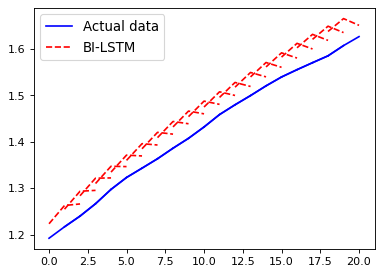

In [101]:
pred3BiLSTM=model.predict(X_test)
pred3BiLSTM = pred3BiLSTM.reshape((pred3BiLSTM.shape[0], pred3BiLSTM.shape[1],n_features))
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred3BiLSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 3 days later")
    plt.legend(['Actual data','BI-LSTM'],fontsize=12)
#plt.legend()       

In [102]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))   

death
Day  1 :
MAE-E2D2 :  0.04218031961142658
Day  2 :
MAE-E2D2 :  0.0537890539930058
Day  3 :
MAE-E2D2 :  0.025817478552571


mean 0.0405956173856678


In [103]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))   

death
Day  1 :
MAE-E2D2 :  3.010409736536591
Day  2 :
MAE-E2D2 :  3.7880781007325575
Day  3 :
MAE-E2D2 :  1.7990681733630498


mean 2.865852003544066


In [104]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    


death
Day  1 :
MAE-E2D2 :  0.04248246595375399
Day  2 :
MAE-E2D2 :  0.05399839715842798
Day  3 :
MAE-E2D2 :  0.026136159436825374


mean 0.04087234084966911


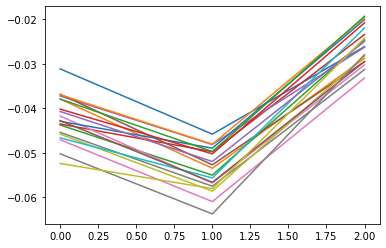

In [106]:
#residual plot

residuals = y_test-pred3BiLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

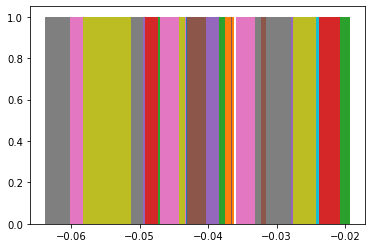

In [107]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

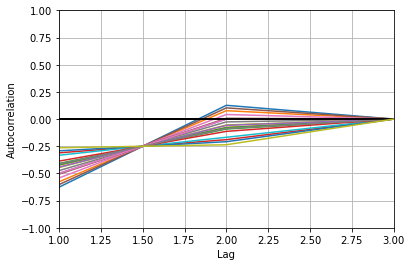

In [108]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)    

In [111]:
#model.save('bilstm_5days.h5')
model=load_model("bilstm_5days.h5")

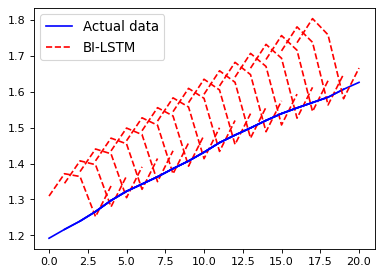

In [112]:
pred5BiLSTM=model.predict(X_test)
pred5BiLSTM= pred5BiLSTM.reshape((pred5BiLSTM.shape[0], pred5BiLSTM.shape[1],n_features))
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred5BiLSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 5 days later")
    plt.legend(['Actual data','BI-LSTM'],fontsize=12)
      

In [113]:
#MAE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    


death
Day  1 :
MAE-E2D2 :  0.15384434381046963
Day  2 :
MAE-E2D2 :  0.19655713061518476
Day  3 :
MAE-E2D2 :  0.14718819957680135
Day  4 :
MAE-E2D2 :  0.02252314724069444
Day  5 :
MAE-E2D2 :  0.043257963294955085


mean 0.11267415690762106


In [114]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))   

death
Day  1 :
MAE-E2D2 :  11.035418159018958
Day  2 :
MAE-E2D2 :  13.879858026062857
Day  3 :
MAE-E2D2 :  10.269185802761282
Day  4 :
MAE-E2D2 :  1.4768065013789804
Day  5 :
MAE-E2D2 :  2.950615704835739


mean 7.922376838811563


In [115]:
#RMSE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))    

death
Day  1 :
MAE-E2D2 :  0.15294939413572028
Day  2 :
MAE-E2D2 :  0.19546672033008206
Day  3 :
MAE-E2D2 :  0.14662678285118746
Day  4 :
MAE-E2D2 :  0.02163858789837822
Day  5 :
MAE-E2D2 :  0.04301073248766679


mean 0.11193844354060696


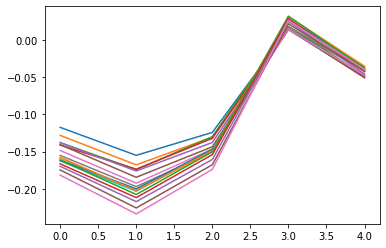

In [116]:
#residual plot

residuals = y_test-pred5BiLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

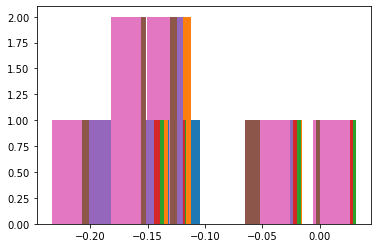

In [117]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

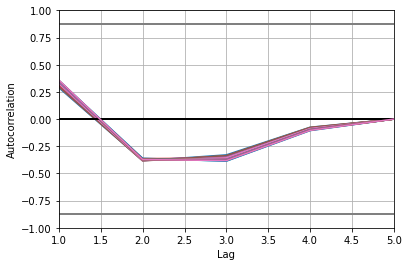

In [118]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [121]:
#model.save('bilstm_7days.h5')
model=load_model("bilstm_7days.h5")

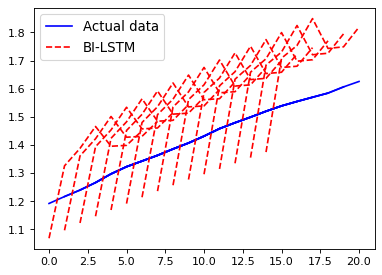

In [122]:
pred7BiLSTM=model.predict(X_test)
pred7BiLSTM = pred7BiLSTM.reshape((pred7BiLSTM.shape[0], pred7BiLSTM.shape[1],n_features))
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred7BiLSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 7 days later")
    plt.legend(['Actual data','BI-LSTM'],fontsize=12)
#plt.legend()       

In [123]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))    

death
Day  1 :
MAE-E2D2 :  0.1310830175832606
Day  2 :
MAE-E2D2 :  0.143718779940867
Day  3 :
MAE-E2D2 :  0.17487683923106195
Day  4 :
MAE-E2D2 :  0.23971515159355009
Day  5 :
MAE-E2D2 :  0.12904018398304953
Day  6 :
MAE-E2D2 :  0.11251165739124085
Day  7 :
MAE-E2D2 :  0.15318644087077352


mean 0.15487601008482907


In [124]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))   

death
Day  1 :
MAE-E2D2 :  9.636585541128357
Day  2 :
MAE-E2D2 :  10.346954337047883
Day  3 :
MAE-E2D2 :  12.420113015120666
Day  4 :
MAE-E2D2 :  16.74415344073787
Day  5 :
MAE-E2D2 :  8.869395853837126
Day  6 :
MAE-E2D2 :  7.605386391382428
Day  7 :
MAE-E2D2 :  10.211805315466707


mean 10.833484842103005


In [125]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    



death
Day  1 :
MAE-E2D2 :  0.13139864965848116
Day  2 :
MAE-E2D2 :  0.14472024738686454
Day  3 :
MAE-E2D2 :  0.1754463643771061
Day  4 :
MAE-E2D2 :  0.24077181619474017
Day  5 :
MAE-E2D2 :  0.1299414353949782
Day  6 :
MAE-E2D2 :  0.11393205949991898
Day  7 :
MAE-E2D2 :  0.15517950127439528


mean 0.1559128676837835


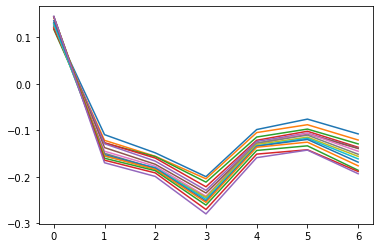

In [126]:
#residual plot

residuals = y_test-pred7BiLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

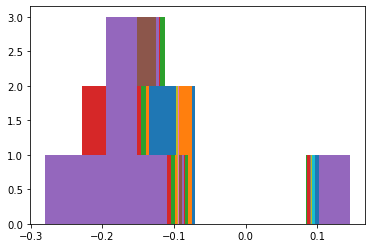

In [127]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

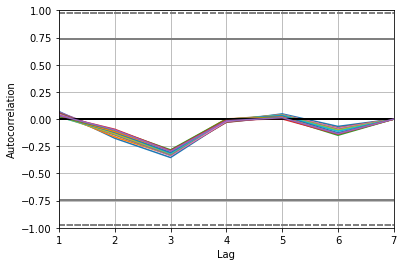

In [128]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [ ]:
#ConvLSTM

In [6]:
n_past=4
n_future=3
train_df,test_df =df[1:int(0.75 * len(df))],df[int(0.75 * len(df)):]
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s
    
    
    
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
    # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y) 


X_train, y_train = split_series(train.values,n_past, n_future)
X_test, y_test = split_series(test.values,n_past, n_future)

n_features = 1
n_seq = 2
n_steps = 2
X_train = X_train.reshape((X_train.shape[0], n_seq, 1, n_steps, n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], n_seq, 1, n_steps, n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1]))

C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_1264/1198612360.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_1264/1198612360.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i]=s_s


In [23]:
# define model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
model.add(Flatten())
model.add(Dense(n_future))
model.compile(optimizer='adam', loss='mse')

In [636]:
history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2,
                        batch_size =16, shuffle = False)

Epoch 1/100
4/4 [==============================] - 6s 177ms/step - loss: 0.3985 - val_loss: 0.4373
Epoch 2/100
4/4 [==============================] - 0s 28ms/step - loss: 0.3872 - val_loss: 0.4374
Epoch 3/100
4/4 [==============================] - 0s 27ms/step - loss: 0.3772 - val_loss: 0.4371
Epoch 4/100
4/4 [==============================] - 0s 24ms/step - loss: 0.3675 - val_loss: 0.4368
Epoch 5/100
4/4 [==============================] - 0s 29ms/step - loss: 0.3578 - val_loss: 0.4364
Epoch 6/100
4/4 [==============================] - 0s 30ms/step - loss: 0.3481 - val_loss: 0.4359
Epoch 7/100
4/4 [==============================] - 0s 33ms/step - loss: 0.3382 - val_loss: 0.4354
Epoch 8/100
4/4 [==============================] - 0s 27ms/step - loss: 0.3279 - val_loss: 0.4347
Epoch 9/100
4/4 [==============================] - 0s 29ms/step - loss: 0.3171 - val_loss: 0.4339
Epoch 10/100
4/4 [==============================] - 0s 32ms/step - loss: 0.3057 - val_loss: 0.4329
Epoch 11/100
4/4 [

Epoch 83/100
4/4 [==============================] - 0s 26ms/step - loss: 1.8795e-04 - val_loss: 0.0303
Epoch 84/100
4/4 [==============================] - 0s 26ms/step - loss: 1.8250e-04 - val_loss: 0.0303
Epoch 85/100
4/4 [==============================] - 0s 27ms/step - loss: 1.7806e-04 - val_loss: 0.0303
Epoch 86/100
4/4 [==============================] - 0s 28ms/step - loss: 1.7397e-04 - val_loss: 0.0303
Epoch 87/100
4/4 [==============================] - 0s 30ms/step - loss: 1.7028e-04 - val_loss: 0.0303
Epoch 88/100
4/4 [==============================] - 0s 27ms/step - loss: 1.6685e-04 - val_loss: 0.0303
Epoch 89/100
4/4 [==============================] - 0s 25ms/step - loss: 1.6390e-04 - val_loss: 0.0303
Epoch 90/100
4/4 [==============================] - 0s 24ms/step - loss: 1.6138e-04 - val_loss: 0.0303
Epoch 91/100
4/4 [==============================] - 0s 24ms/step - loss: 1.5900e-04 - val_loss: 0.0303
Epoch 92/100
4/4 [==============================] - 0s 24ms/step - loss: 

In [7]:
#model.save('ConvLSTM_3days.h5')
model=load_model("ConvLSTM_3days.h5")

In [8]:
pred3ConvLSTM=model.predict(X_test)

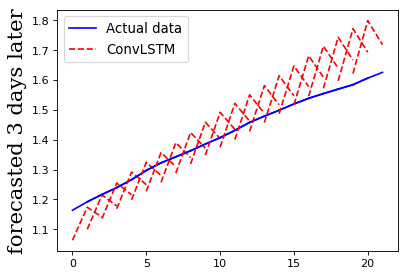

In [10]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
font1 = {'family':'Serif','color':'black','size':19}

for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred3ConvLSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    plt.ylabel("forecasted 3 days later", fontdict = font1)
    plt.legend(['Actual data','ConvLSTM'],fontsize=12)


In [28]:
#MAE
from sklearn.metrics import mean_absolute_error
pred3ConvLSTM = pred3ConvLSTM.reshape((pred3ConvLSTM.shape[0], pred3ConvLSTM.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))     

death
Day  1 :
MAE-E2D2 :  0.04512936423161094
Day  2 :
MAE-E2D2 :  0.08868546981457101
Day  3 :
MAE-E2D2 :  0.04200272088915795


mean 0.058605851645113304


In [134]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))   

death
Day  1 :
MAE-E2D2 :  3.452632387976478
Day  2 :
MAE-E2D2 :  5.953511560135518
Day  3 :
MAE-E2D2 :  2.924095241758231


mean 4.110079729956742


In [135]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    




death
Day  1 :
MAE-E2D2 :  0.053010196543701454
Day  2 :
MAE-E2D2 :  0.10648662158510568
Day  3 :
MAE-E2D2 :  0.05080738348504867


mean 0.07010140053795193


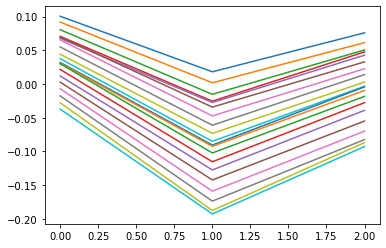

In [29]:
#residual plot

residuals = y_test-pred3ConvLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

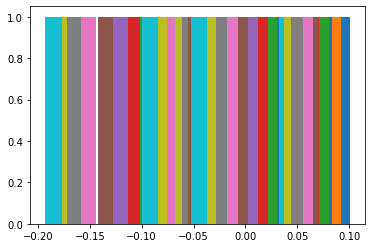

In [137]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

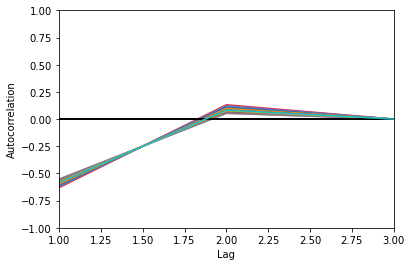

In [138]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel

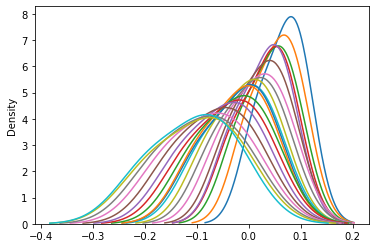

In [30]:
import seaborn as sns
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    sns.distplot(residual, hist=False)

In [208]:
#model.save('ConvLSTM_5days.h5')
model=load_model("ConvLSTM_5days.h5")

In [209]:
pred5ConvLSTM=model.predict(X_test)

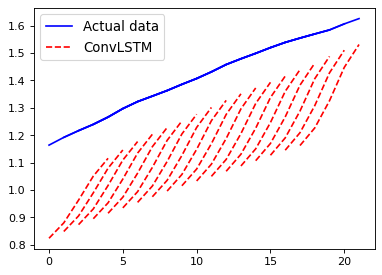

In [210]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred5ConvLSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 5 days later")
    plt.legend(['Actual data','ConvLSTM'],fontsize=12)


In [211]:
#MAE
from sklearn.metrics import mean_absolute_error
pred5ConvLSTM = pred5ConvLSTM.reshape((pred5ConvLSTM.shape[0], pred5ConvLSTM.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))     

death
Day  1 :
MAE-E2D2 :  0.37030616775083747
Day  2 :
MAE-E2D2 :  0.33232800862479245
Day  3 :
MAE-E2D2 :  0.26230374301601656
Day  4 :
MAE-E2D2 :  0.17869897197554951
Day  5 :
MAE-E2D2 :  0.12562639868725275


mean 0.25385265801088974


In [212]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))    
     

death
Day  1 :
MAE-E2D2 :  27.099209699829608
Day  2 :
MAE-E2D2 :  23.93672917718922
Day  3 :
MAE-E2D2 :  18.623402356069697
Day  4 :
MAE-E2D2 :  12.552600358963717
Day  5 :
MAE-E2D2 :  8.745100536475988


mean 18.191408425705646


In [146]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    


death
Day  1 :
MAE-E2D2 :  0.37079029733392505
Day  2 :
MAE-E2D2 :  0.33262350656596495
Day  3 :
MAE-E2D2 :  0.2624099282371294
Day  4 :
MAE-E2D2 :  0.1789494316695645
Day  5 :
MAE-E2D2 :  0.12678123871921979


mean 0.2543108805051607


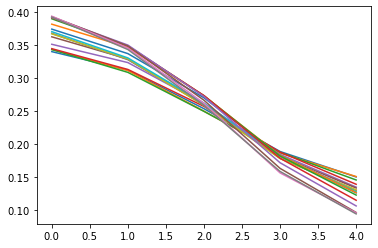

In [147]:
#residual plot

residuals = y_test-pred5ConvLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

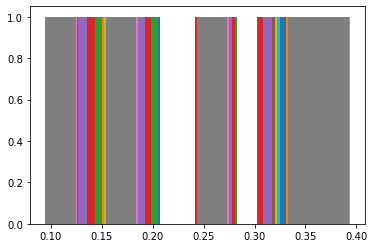

In [148]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

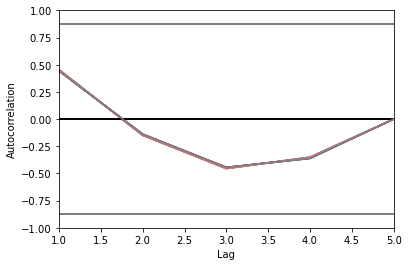

In [149]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [214]:
#model.save('ConvLSTM_7days.h5')
model=load_model("ConvLSTM_7days.h5")

In [215]:
pred7ConvLSTM=model.predict(X_test)

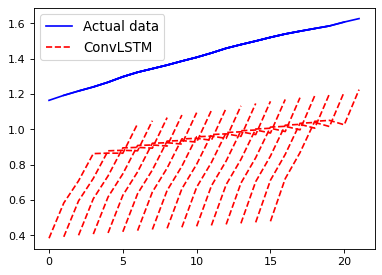

In [216]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred7ConvLSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 7 days later")
    plt.legend(['Actual data','ConvLSTM'],fontsize=12)


In [217]:
#MAE
from sklearn.metrics import mean_absolute_error
pred7ConvLSTM = pred7ConvLSTM.reshape((pred7ConvLSTM.shape[0], pred7ConvLSTM.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))     

death
Day  1 :
MAE-E2D2 :  0.9138768092017879
Day  2 :
MAE-E2D2 :  0.7157532553427578
Day  3 :
MAE-E2D2 :  0.6013624143655842
Day  4 :
MAE-E2D2 :  0.4568469856248871
Day  5 :
MAE-E2D2 :  0.47464341825411105
Day  6 :
MAE-E2D2 :  0.5089702996086771
Day  7 :
MAE-E2D2 :  0.3454582129345865


mean 0.5738444850474844


In [218]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))    

death
Day  1 :
MAE-E2D2 :  67.70137894789704
Day  2 :
MAE-E2D2 :  52.09066176688106
Day  3 :
MAE-E2D2 :  43.03753553213328
Day  4 :
MAE-E2D2 :  32.15995266015488
Day  5 :
MAE-E2D2 :  32.937327854479356
Day  6 :
MAE-E2D2 :  34.79439681721265
Day  7 :
MAE-E2D2 :  23.269852233776874


mean 40.85587225893359


In [219]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    


death
Day  1 :
MAE-E2D2 :  0.9174075093096762
Day  2 :
MAE-E2D2 :  0.7187856891279911
Day  3 :
MAE-E2D2 :  0.6040694615085549
Day  4 :
MAE-E2D2 :  0.45929916211043853
Day  5 :
MAE-E2D2 :  0.4766056920382044
Day  6 :
MAE-E2D2 :  0.511197216986142
Day  7 :
MAE-E2D2 :  0.34736130172960494


mean 0.5763894332586589


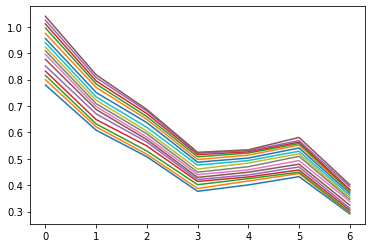

In [157]:
#residual plot

residuals = y_test-pred7ConvLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

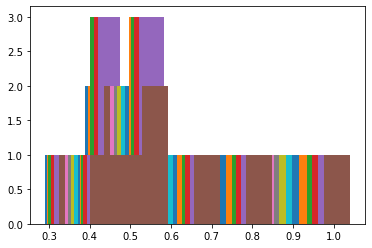

In [158]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

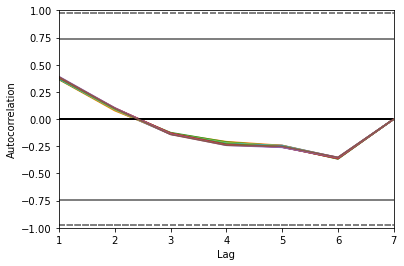

In [159]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [ ]:
#GRU

In [220]:
train_df,test_df =df[1:int(0.75 * len(df))],df[int(0.75 * len(df)):] 
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_2796/3905142482.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_2796/3905142482.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i]=s_s


In [221]:
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
    # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [237]:
n_past = 5
n_future =7
n_features = 1
X_train, y_train = split_series(train.values,n_past, n_future)

In [238]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1]))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1]))

In [186]:
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (64, 5, 1)
y_train.shape:  (64, 7)
X_test.shape:  (15, 5, 1)
y_test.shape:  (15, 7)


In [663]:
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = n_future)) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_gru = create_gru(64)

In [664]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2,
                        batch_size = 16, shuffle = False, 
                        )
    return history
history_gru = fit_model(model_gru)


Epoch 1/100
4/4 [==============================] - 8s 386ms/step - loss: 0.3472 - val_loss: 0.4145
Epoch 2/100
4/4 [==============================] - 0s 31ms/step - loss: 0.2476 - val_loss: 0.3969
Epoch 3/100
4/4 [==============================] - 0s 27ms/step - loss: 0.1733 - val_loss: 0.3781
Epoch 4/100
4/4 [==============================] - 0s 28ms/step - loss: 0.1154 - val_loss: 0.3552
Epoch 5/100
4/4 [==============================] - 0s 27ms/step - loss: 0.0762 - val_loss: 0.3262
Epoch 6/100
4/4 [==============================] - 0s 27ms/step - loss: 0.0544 - val_loss: 0.2918
Epoch 7/100
4/4 [==============================] - 0s 32ms/step - loss: 0.0503 - val_loss: 0.2572
Epoch 8/100
4/4 [==============================] - 0s 28ms/step - loss: 0.0441 - val_loss: 0.2243
Epoch 9/100
4/4 [==============================] - 0s 30ms/step - loss: 0.0368 - val_loss: 0.1940
Epoch 10/100
4/4 [==============================] - 0s 28ms/step - loss: 0.0378 - val_loss: 0.1637
Epoch 11/100
4/4 [

In [224]:
#model_gru.save('GRU_3days.h5')
model_gru=load_model("GRU_3days.h5")

In [225]:
pred3GRU=model_gru.predict(X_test)

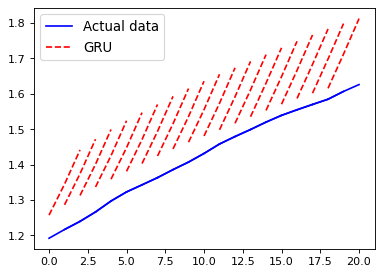

In [226]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred3GRU[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 3 days later")
    plt.legend(['Actual data','GRU'],fontsize=12)


In [227]:
#MAE
from sklearn.metrics import mean_absolute_error
pred3GRU = pred3GRU.reshape((pred3GRU.shape[0], pred3GRU.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred3GRU[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred3GRU[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors)) 
    

death
Day  1 :
MAE-E2D2 :  0.05033313703640152
Day  2 :
MAE-E2D2 :  0.12063726929692875
Day  3 :
MAE-E2D2 :  0.19837651400435966


mean 0.1231156401125633


In [229]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred3GRU[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred3GRU[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))  



death
Day  1 :
MAE-E2D2 :  3.7037573886230897
Day  2 :
MAE-E2D2 :  8.574180874825805
Day  3 :
MAE-E2D2 :  13.827892033250109


mean 8.701943432233001


In [169]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3GRU[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3GRU[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))  



death
Day  1 :
MAE-E2D2 :  0.05249491317351843
Day  2 :
MAE-E2D2 :  0.12100029145829849
Day  3 :
MAE-E2D2 :  0.1984785380944274


mean 0.12399124757541476


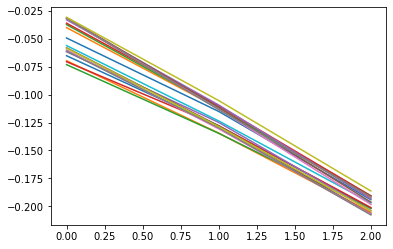

In [170]:
#residual plot

residuals = y_test-pred3GRU
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

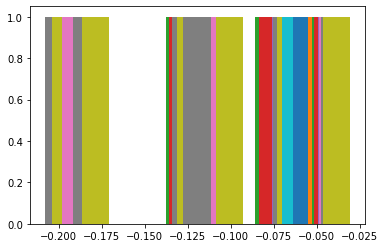

In [171]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

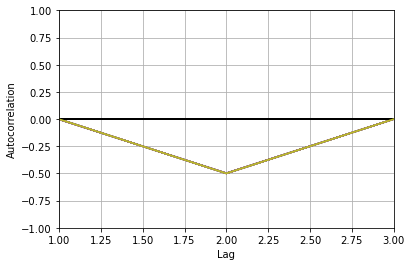

In [172]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [232]:
#model_gru.save('GRU_5days.h5')
model_gru=load_model("GRU_5days.h5")

In [233]:
pred5GRU=model_gru.predict(X_test)


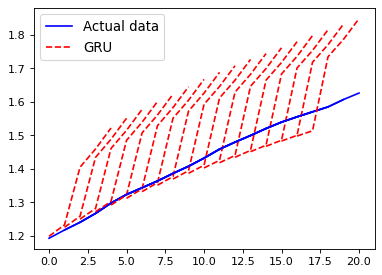

In [234]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred5GRU[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 5 days later")
    plt.legend(['Actual data','GRU'],fontsize=12)


In [235]:
#MAE
from sklearn.metrics import mean_absolute_error
pred5GRU = pred5GRU.reshape((pred5GRU.shape[0], pred5GRU.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred5GRU[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred5GRU[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors)) 
    

death
Day  1 :
MAE-E2D2 :  0.025747516903901556
Day  2 :
MAE-E2D2 :  0.025915787454757415
Day  3 :
MAE-E2D2 :  0.15639660822556634
Day  4 :
MAE-E2D2 :  0.18815316357050463
Day  5 :
MAE-E2D2 :  0.2291317544876991


mean 0.12506896612848578


In [236]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred5GRU[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred5GRU[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))  


death
Day  1 :
MAE-E2D2 :  1.7685023381598466
Day  2 :
MAE-E2D2 :  1.7656407303211412
Day  3 :
MAE-E2D2 :  11.061407312970672
Day  4 :
MAE-E2D2 :  13.081447985905553
Day  5 :
MAE-E2D2 :  15.67603167497602


mean 8.670606008466645


In [180]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5GRU[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5GRU[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))  



death
Day  1 :
MAE-E2D2 :  0.032118088163631396
Day  2 :
MAE-E2D2 :  0.03248590372965407
Day  3 :
MAE-E2D2 :  0.15662752871219113
Day  4 :
MAE-E2D2 :  0.188269584545632
Day  5 :
MAE-E2D2 :  0.22919020332653464


mean 0.12773826169552865


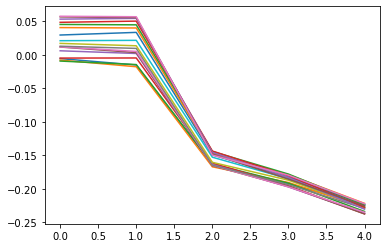

In [181]:
#residual plot

residuals = y_test-pred5GRU
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

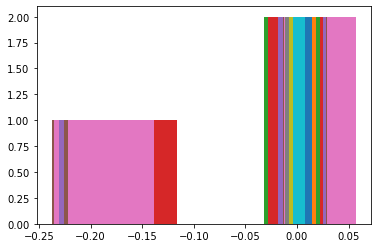

In [182]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

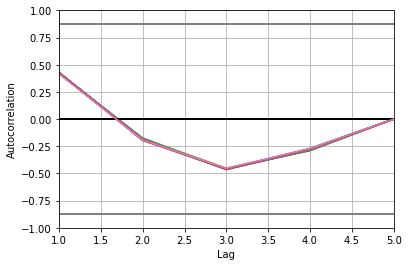

In [183]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [239]:
#model_gru.save('GRU_7days.h5')
model_gru=load_model("GRU_7days.h5")

In [240]:
pred7GRU=model_gru.predict(X_test)


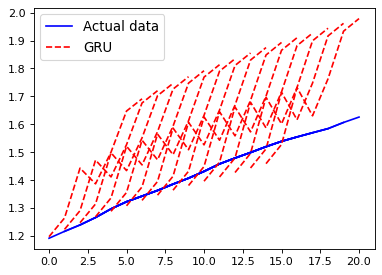

In [241]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred7GRU[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 7days later") 
    plt.legend(['Actual data','GRU'],fontsize=12)

In [242]:
#MAE
from sklearn.metrics import mean_absolute_error
pred7GRU = pred7GRU.reshape((pred7GRU.shape[0], pred7GRU.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred7GRU[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred7GRU[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors)) 
    

death
Day  1 :
MAE-E2D2 :  0.02510414510825975
Day  2 :
MAE-E2D2 :  0.02562244914497166
Day  3 :
MAE-E2D2 :  0.19234936069509193
Day  4 :
MAE-E2D2 :  0.0906848635330439
Day  5 :
MAE-E2D2 :  0.1933475796002167
Day  6 :
MAE-E2D2 :  0.331910720183701
Day  7 :
MAE-E2D2 :  0.356314238315435


mean 0.17361905094010283


In [243]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred7GRU[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred7GRU[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))  


death
Day  1 :
MAE-E2D2 :  1.7562051714007167
Day  2 :
MAE-E2D2 :  1.9439406060448725
Day  3 :
MAE-E2D2 :  13.785490083453992
Day  4 :
MAE-E2D2 :  6.469677045891871
Day  5 :
MAE-E2D2 :  13.435407815078074
Day  6 :
MAE-E2D2 :  22.6587867547709
Day  7 :
MAE-E2D2 :  23.98100801078221


mean 12.004359355346091


In [192]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7GRU[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7GRU[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))  



death
Day  1 :
MAE-E2D2 :  0.03160308586743728
Day  2 :
MAE-E2D2 :  0.03049729212402836
Day  3 :
MAE-E2D2 :  0.1926496095118899
Day  4 :
MAE-E2D2 :  0.09308025460137458
Day  5 :
MAE-E2D2 :  0.19375315611994734
Day  6 :
MAE-E2D2 :  0.33194993643660287
Day  7 :
MAE-E2D2 :  0.35633151604104485


mean 0.17569497867176073


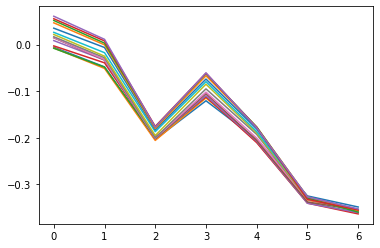

In [193]:
#residual plot

residuals = y_test-pred7GRU
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

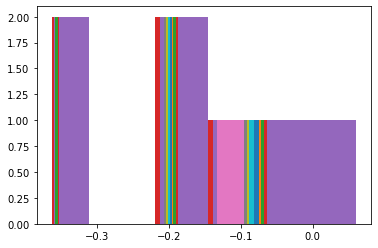

In [194]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

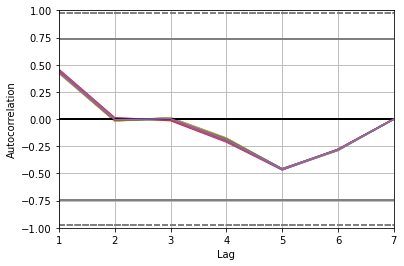

In [195]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

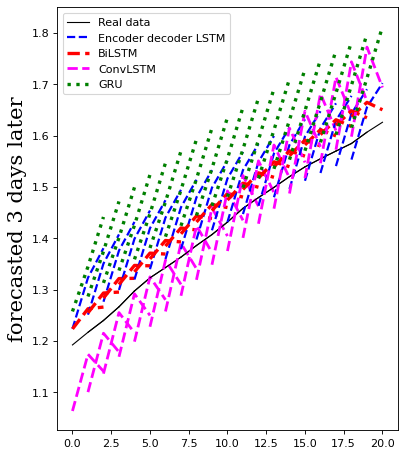

In [202]:
from matplotlib.pyplot import figure
figure(figsize=(5.5,7), dpi=80)
font1 = {'family':'Serif','color':'black','size':19}
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"black",linewidth=1)
    plt.plot(range(i,i+n_future),pred3LSTM[i],"blue",linestyle='dashed',linewidth=2)
    plt.plot(range(i,i+n_future),pred3BiLSTM[i],"red",linestyle='dashed',linewidth=3)
    plt.plot(range(i,i+n_future),pred3ConvLSTM[i],"magenta",linestyle='dashed',linewidth=2.5)
    plt.plot(range(i,i+n_future),pred3GRU[i],"green",linestyle='dotted',linewidth=3)
    #plt.xlabel("days")   
    plt.ylabel("forecasted 3 days later", fontdict = font1)
    plt.legend(['Real data','Encoder decoder LSTM','BiLSTM','ConvLSTM','GRU'],fontsize=10)
#plt.legend()

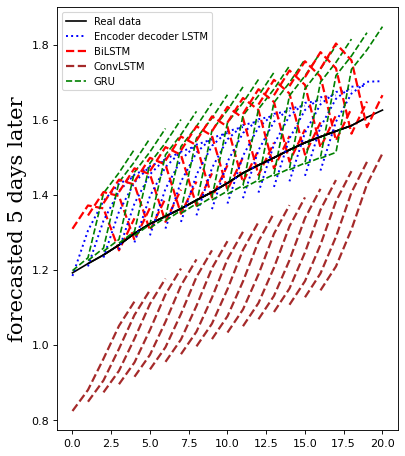

In [199]:
from matplotlib.pyplot import figure
figure(figsize=(5.5,7), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"black")
    plt.plot(range(i,i+n_future),pred5LSTM[i],"blue",linestyle='dotted',linewidth=1.75)
    plt.plot(range(i,i+n_future),pred5BiLSTM[i],"red",linestyle='dashed',linewidth=2)
    plt.plot(range(i,i+n_future),pred5ConvLSTM[i],"brown",linestyle='dashed',linewidth=2)
    plt.plot(range(i,i+n_future),pred5GRU[i],"green",linestyle='dashed')
    #plt.xlabel("days")   
    plt.ylabel("forecasted 5 days later", fontdict = font1)
    plt.legend(['Real data','Encoder decoder LSTM','BiLSTM','ConvLSTM','GRU'],fontsize=9)
#plt.legend()

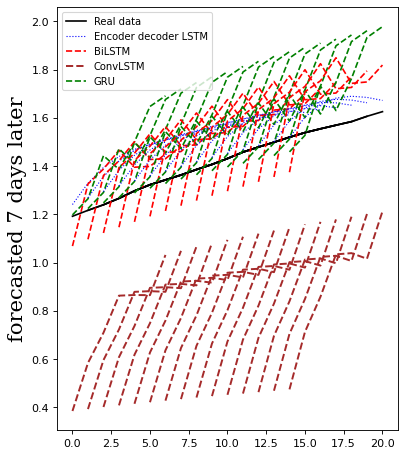

In [196]:
from matplotlib.pyplot import figure
figure(figsize=(5.5,7), dpi=80)

for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"black")
    plt.plot(range(i,i+n_future),pred7LSTM[i],"blue",linestyle='dotted',linewidth=1)
    plt.plot(range(i,i+n_future),pred7BiLSTM[i],"red",linestyle='dashed')
    plt.plot(range(i,i+n_future),pred7ConvLSTM[i],"brown",linestyle='dashed',linewidth=1.75)
    plt.plot(range(i,i+n_future),pred7GRU[i],"green",linestyle='dashed')
    #plt.xlabel("days")   
    plt.ylabel("forecasted 7 days later", fontdict = font1)
    plt.legend(['Real data','Encoder decoder LSTM','BiLSTM','ConvLSTM','GRU'],fontsize=9)
#plt.legend()